# Object-Scene Scaling Analysis

In [191]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [4]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [7]:
data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot'

In [8]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  9


In [11]:
num_trials = 24

In [35]:
def removeMissedTrials(input_data, num_trials):
    """
    Remove trials where keypress was 'none'
    
    Remove participants who have more than 10% of their data removed
    """
    
    missedTrials_participants = {}
    total_missed = 0
    total = 0
    for idx, row in input_data.iterrows():
        total += 1
        keyPress = row['keyPress']
        if keyPress == 'none':
            total_missed += 1
            subjID = row['subjID']
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            # remove trials with keyPress = none 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(num_trials * 0.1)
    
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))
    print("Percent of missed trials: ", total_missed/total)

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)
    
    return input_data

In [36]:
missed_trial_cleaned_data = removeMissedTrials(input_data, num_trials)

Number of participants with 10% or more missed trials:  0
Percent of missed trials:  0.0


In [75]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Remove participants who have more than 10% of their data removed
    
    Returns:
        dataframe with outlier RT trials and outlier participants removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    print("Percent of RT trials outside the outlier range: ", total_RT_outliers/total)
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    return df2, list_trialRT

In [76]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(missed_trial_cleaned_data, [250, 2000], num_trials)


Number of Participants with 10% or more trials outside their RT range:  0
Percent of RT trials outside the outlier range:  0.0


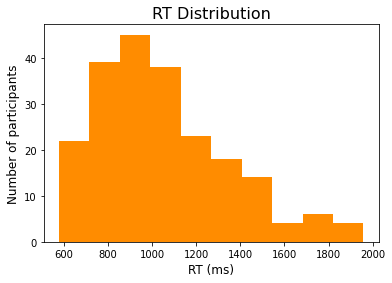

In [80]:
plt.figure()
plt.hist(trialRTs_distribution, color='darkorange')
plt.title('RT Distribution', fontsize=16)
plt.xlabel('RT (ms)', fontsize=12)
plt.ylabel('Number of participants', fontsize=12)
plt.show()

In [73]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
                    
        # minimum number of trials correct the participant must have to be included
        threshold = math.floor(num_trials * accuracy_threshold)
        if subj_num_correct_trials < threshold:
            remove.append(subj)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print('Minimum number of trials correct: ', threshold)
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    return df2, list_trials_correct 

In [74]:
Accuracy_cleaned_data, correct_trials_distribution = Accuracy_Cleaning(RT_cleaned_data, 0.7, num_trials)


Minimum number of trials correct:  16
Number of Participants with accuracy below 70%:  0


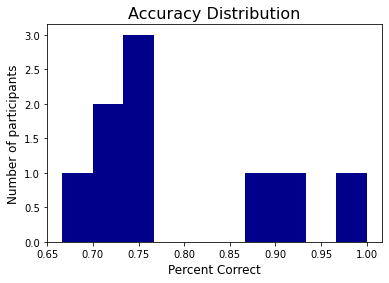

In [84]:
plt.figure()
plt.hist((np.array(correct_trials_distribution))/num_trials, color='darkblue')
plt.title('Accuracy Distribution', fontsize=16)
plt.xlabel('Percent Correct', fontsize=12)
plt.ylabel('Number of participants', fontsize=12)
plt.show()

In [87]:
final_data = Accuracy_cleaned_data.copy(deep=True)
final_data

,subjID,experimentName,versionName,windowWidth,windowHeight,screenWidth,screenHeight,startDate,startTime,pracTries,...,objectCategory,sceneImage,objectImage,semanticMatch,sceneZoom,keyPress,accuracy,RT,experimentTime,totalTime
0,955568,OSS,v1,1590,940,2560,1440,9-3-2022,10-3-8,1,...,classroom,g4_zo.png,c_notebook.png,0.0,zo,m,1,1239,33704,58031
1,955568,OSS,v1,1590,940,2560,1440,9-3-2022,10-3-8,1,...,gym,c1_zi.png,g_sneaker.png,0.0,zi,m,1,1948,33704,58031
2,955568,OSS,v1,1590,940,2560,1440,9-3-2022,10-3-8,1,...,classroom,c5_zi.png,c_eraser.png,1.0,zi,c,1,1907,33704,58031
3,955568,OSS,v1,1590,940,2560,1440,9-3-2022,10-3-8,1,...,classroom,c4_zo.png,c_mouse.png,1.0,zo,c,1,780,33704,58031
4,955568,OSS,v1,1590,940,2560,1440,9-3-2022,10-3-8,1,...,bathroom,b2_zo.png,b_soap.png,1.0,zo,c,1,754,33704,58031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,343573,OSS,v1,1536,662,1536,864,9-3-2022,9-46-37,2,...,classroom,c2_zc.png,c_backpack.png,1.0,zc,c,1,1334,40402,119647
212,343573,OSS,v1,1536,662,1536,864,9-3-2022,9-46-37,2,...,gym,g4_zi.png,g_boxingglove.png,1.0,zi,c,1,1134,40402,119647
213,343573,OSS,v1,1536,662,1536,864,9-3-2022,9-46-37,2,...,gym,c0_zc.png,g_gymbag.png,0.0,zc,c,0,1121,40402,119647
214,343573,OSS,v1,1536,662,1536,864,9-3-2022,9-46-37,2,...,classroom,c5_zo.png,c_computer.png,1.0,zo,c,1,909,40402,119647


In [101]:
# data split by semantic match
catCongruent_df = final_data.loc[final_data['semanticMatch'] == 1.0]
catIncongruent_df = final_data.loc[final_data['semanticMatch'] == 0.0]


In [102]:
# data split by zoom level 
zo_df = final_data.loc[final_data['sceneZoom'] == 'zo']
zi_df = final_data.loc[final_data['sceneZoom'] == 'zi']
zc_df = final_data.loc[final_data['sceneZoom'] == 'zc']


In [103]:
# semantic matched data across all zooms 
zo_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zo']
zi_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zi']
zc_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zc']


In [104]:
# semantic mis-matched data across all zooms 
zo_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zo']
zi_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zi']
zc_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zc']


## Accuracy

In [111]:
catCongruent_acc = np.sum(np.array(catCongruent_df['accuracy']))/len(np.array(catCongruent_df['accuracy']))
catIncongruent_acc = np.sum(np.array(catIncongruent_df['accuracy']))/len(np.array(catIncongruent_df['accuracy']))

catCongruent_acc, catIncongruent_acc

(0.8846153846153846, 0.7238095238095238)

In [112]:
zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))
zc_acc = np.sum(np.array(zc_df['accuracy']))/len(np.array(zc_df['accuracy']))

zo_acc, zi_acc, zc_acc

(0.8529411764705882, 0.7714285714285715, 0.7887323943661971)

In [115]:
zo_catCongruent_acc = np.sum(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc = np.sum(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc = np.sum(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))

zo_catCongruent_acc, zi_catCongruent_acc, zc_catCongruent_acc

(0.8857142857142857, 0.8529411764705882, 0.9142857142857143)

In [223]:
zo_catCongruent_acc_sem = sem(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc_sem = sem(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc_sem = sem(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))



In [117]:
zo_catIncongruent_acc = np.sum(np.array(zo_catIncongruent['accuracy']))/len(np.array(zo_catIncongruent['accuracy']))
zi_catIncongruent_acc = np.sum(np.array(zi_catIncongruent['accuracy']))/len(np.array(zi_catIncongruent['accuracy']))
zc_catIncongruent_acc = np.sum(np.array(zc_catIncongruent['accuracy']))/len(np.array(zc_catIncongruent['accuracy']))

zo_catIncongruent_acc, zi_catIncongruent_acc, zc_catIncongruent_acc

(0.8181818181818182, 0.6944444444444444, 0.6666666666666666)

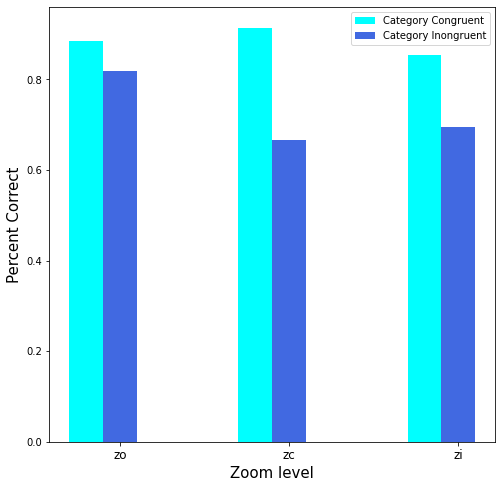

In [225]:
plt.figure(figsize=[8,8])
x = np.arange(3)
#                          z0                   zc                  zi
Acc_catCongruent =   [zo_catCongruent_acc, zc_catCongruent_acc, zi_catCongruent_acc]

Acc_catIncongruent = [zo_catIncongruent_acc, zc_catIncongruent_acc, zi_catIncongruent_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_catCongruent, width, color='cyan', label='Category Congruent')
plt.bar(x, Acc_catIncongruent, width, color='royalblue', label='Category Inongruent')
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Percent Correct", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()

### Accuracy by Scene Category

In [244]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['gym', 'classroom', 'bathroom', 'kitchen']

In [247]:
scenes = []
scenes_acc = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_acc = np.sum(np.array(scene_df['accuracy']))/len(np.array(scene_df['accuracy']))
    scenes.append(scene)
    scenes_acc.append(scene_acc)


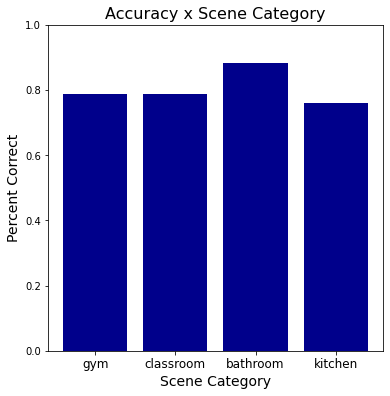

In [262]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.ylim([0, 1])
plt.bar(np.arange(len(scenes)), scenes_acc, color='darkblue')
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('Percent Correct', fontsize=14)
plt.title('Accuracy x Scene Category', fontsize=16)

plt.show();

## RT

In [226]:
catCongruent_RT = np.mean(np.array(catCongruent_df['RT']))
catIncongruent_RT = np.mean(np.array(catIncongruent_df['RT']))

catCongruent_RT, catIncongruent_RT

(1024.3365384615386, 1087.5809523809523)

In [227]:
zo_RT = np.mean(np.array(zo_df['RT']))
zi_RT = np.mean(np.array(zi_df['RT']))
zc_RT = np.mean(np.array(zc_df['RT']))

zo_RT, zi_RT, zc_RT

(1013.25, 1136.7, 1017.7042253521126)

In [228]:
zo_catCongruent_RT = np.mean(np.array(zo_catCongruent['RT']))
zi_catCongruent_RT = np.mean(np.array(zi_catCongruent['RT']))
zc_catCongruent_RT = np.mean(np.array(zc_catCongruent['RT']))

zo_catCongruent_RT, zi_catCongruent_RT, zc_catCongruent_RT

(976.8, 1090.5882352941176, 1007.5142857142857)

In [230]:
zo_catCongruent_RT_sem = sem(np.array(zo_catCongruent['RT']))
zi_catCongruent_RT_sem = sem(np.array(zi_catCongruent['RT']))
zc_catCongruent_RT_sem = sem(np.array(zc_catCongruent['RT']))


In [231]:
zo_catIncongruent_RT = np.mean(np.array(zo_catIncongruent['RT']))
zi_catIncongruent_RT = np.mean(np.array(zi_catIncongruent['RT']))
zc_catIncongruent_RT = np.mean(np.array(zc_catIncongruent['RT']))

zo_catIncongruent_RT, zi_catIncongruent_RT, zc_catIncongruent_RT

(1051.909090909091, 1180.25, 1027.611111111111)

In [232]:
zo_catIncongruent_RT_sem = sem(np.array(zo_catIncongruent['RT']))
zi_catIncongruent_RT_sem = sem(np.array(zi_catIncongruent['RT']))
zc_catIncongruent_RT_sem = sem(np.array(zc_catIncongruent['RT']))


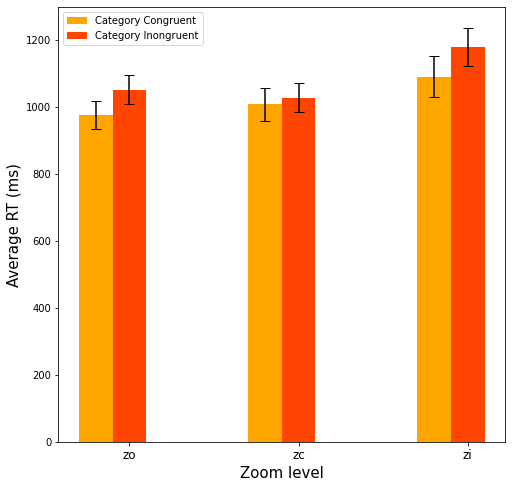

In [233]:
plt.figure(figsize=[8,8])
x = np.arange(3)

#                          z0                   zc                  zi
RT_catCongruent =   [zo_catCongruent_RT, zc_catCongruent_RT, zi_catCongruent_RT]
RT_catCongruent_sem = [zo_catCongruent_RT_sem, zc_catCongruent_RT_sem, zi_catCongruent_RT_sem]
#                          z0                   zc                  zi

RT_catIncongruent = [zo_catIncongruent_RT, zc_catIncongruent_RT, zi_catIncongruent_RT]
RT_catIncongruent_sem = [zo_catIncongruent_RT_sem, zc_catIncongruent_RT_sem, zi_catIncongruent_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_catCongruent, width, color='orange', label='Category Congruent', yerr=RT_catCongruent_sem, capsize=5)
plt.bar(x, RT_catIncongruent, width, color='orangered', label='Category Inongruent', yerr=RT_catIncongruent_sem, capsize=5)
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Average RT (ms)", fontsize=15)
plt.legend(loc=2, fontsize=10)
plt.show()

In [263]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['gym', 'classroom', 'bathroom', 'kitchen']

In [264]:
scenes = []
scenes_RT = []
scenes_sem = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_RT = np.mean(np.array(scene_df['RT']))
    scene_sem = sem(np.array(scene_df['RT']))
    scenes.append(scene)
    scenes_RT.append(scene_RT)
    scenes_sem.append(scene_sem)


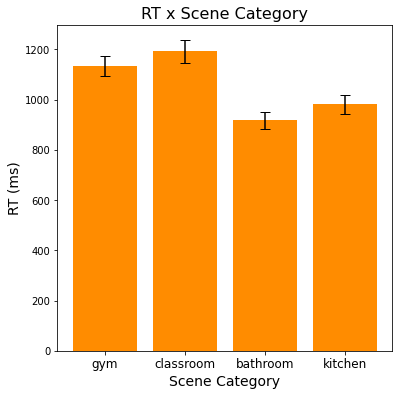

In [267]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.bar(np.arange(len(scenes)), scenes_RT, color='darkorange', yerr = scenes_sem, capsize=5)
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('RT (ms)', fontsize=14)
plt.title('RT x Scene Category', fontsize=16)

plt.show();